<a href="https://colab.research.google.com/github/apachon/tensorflow/blob/master/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with preprocessed text: Movie reviews

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

We'll use the [IMDB dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.

This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.2.0


## Download the IMDB dataset

The IMDB movie reviews dataset comes packaged in `tfds`. It has already been preprocessed so that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

The following code downloads the IMDB dataset to your machine (or uses a cached copy if you've already downloaded it):

To encode your own text see the [Loading text tutorial](../load_data/text.ipynb)

In [2]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3LA442/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3LA442/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3LA442/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


<a id="encoder"></a>

## Try the encoder

 The dataset `info` includes the text encoder (a `tfds.features.text.SubwordTextEncoder`).

In [4]:
encoder = info.features['text'].encoder

In [5]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string:

In [6]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


The encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be.

In [7]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Explore the data

Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. 

The text of reviews have been converted to integers, where each integer represents a specific word-piece in the dictionary. 

Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Here's what the first review looks like:

In [8]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


The info structure contains the encoder/decoder. The encoder can be used to recover the original text:


In [9]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

## Prepare the data for training

You will want to create batches of training data for your model. The reviews are all different lengths, so use `padded_batch` to zero pad the sequences while batching:


In [11]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32))

test_batches = (
    test_data
    .padded_batch(32))

Each batch will have a shape of (batch_size, sequence_length) because the padding is dynamic each batch will have a different length:

In [12]:
for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (32, 770)
label shape: (32,)
Batch shape: (32, 1032)
label shape: (32,)


## Build the model

The neural network is created by stacking layers—this requires two main architectural decisions:

* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a "Continuous bag of words" style model for this problem:

Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output.  To fix this, see the [masking and padding guide](../../guide/keras/masking_and_padding.ipynb).

In [13]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  *To learn more about embeddings, see the [word embedding tutorial](../text/word_embeddings.ipynb).*
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
4. The last layer is densely connected with a single output node. This uses the default *linear* activation function that outputs *logits* for numerical stability. Another option is to use the *sigmoid* activation function that returns a float value between 0 and 1, representing a probability, or confidence level.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), we'll use the `binary_crossentropy` loss function.

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [14]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Train the model by passing the `Dataset` object to the model's fit function. Set the number of epochs.

In [15]:
history = model.fit(train_batches,
                    epochs=30,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/30
782/782 [==============================] - 7s 9ms/step - loss: 0.6806 - accuracy: 0.5011 - val_loss: 0.6609 - val_accuracy: 0.5135
Epoch 2/30
782/782 [==============================] - 6s 8ms/step - loss: 0.6134 - accuracy: 0.5634 - val_loss: 0.5885 - val_accuracy: 0.5813
Epoch 3/30
782/782 [==============================] - 6s 8ms/step - loss: 0.5332 - accuracy: 0.6764 - val_loss: 0.5259 - val_accuracy: 0.6917
Epoch 4/30
782/782 [==============================] - 7s 8ms/step - loss: 0.4695 - accuracy: 0.7555 - val_loss: 0.4773 - val_accuracy: 0.7521
Epoch 5/30
782/782 [==============================] - 7s 8ms/step - loss: 0.4161 - accuracy: 0.8074 - val_loss: 0.4402 - val_accuracy: 0.7927
Epoch 6/30
782/782 [==============================] - 6s 8ms/step - loss: 0.3763 - accuracy: 0.8375 - val_loss: 0.4139 - val_accuracy: 0.8073
Epoch 7/30
782/782 [==============================] - 7s 9ms/step - loss: 0.3442 - accuracy: 0.8545 - val_loss: 0.3966 - val_accuracy: 0.8135
Epoch 

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [16]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3412 - accuracy: 0.8735
Loss:  0.3412087857723236
Accuracy:  0.8734800219535828


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.


## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:


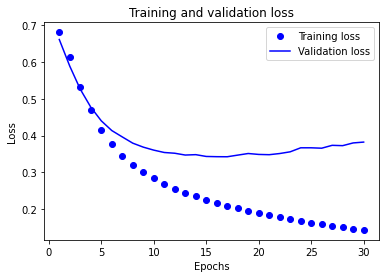

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

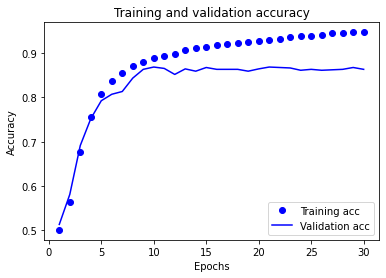

In [19]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.
